#Modelo de clasificación: Procesado completo + PCA + Red Neuronal

El modelo solución proviene de un arduo análisis de como mejorar el desepeño en la predicción mediante el uso de una red neuronal que incluyó análisis inicial de posibles arquitecturas de red, para esto se utilizo la librería de tensorflow para crear y entrenar las diferentes redes (Ver Notebook """)

Posteriormente se hizo análisis sobre algunas posibles mejoras, tales como target encoding y capas de embedding, especialmente para una de las columnas que ha representado el mayor desafio; el programa académico. Finalmente el modelo resultante consiste en tres etapas:

1. Preprocesamiento del dataset: El descrito en el Notebook *02 - preprocesado.ipynb* que fundamentalmente transforma los datos descriptivos a codificaciones binarias, de categorías ordenadas o codificación one-hot, y para el caso especial del programa académico una clasificación por áreas de conocimiento

2. Postprocesamiento que consiste en varias etapas:

  2.1. Labeling: Se mantuvo la columna de programa académico y se adiciona una columna de "labeling" para añadir capas de embedding en la red

  2.2. Target encoding: La columna de programa académico y las correspondientes a la educación de los padres se codificaron a través de la media de la columna a predecir de acuerdo a cada categoría distinta

  2.3. Escalado o normalización: Se efectua normalización de las columnas ordinales y de valores continuos (coeficientes especiales)

  2.4. Descomposición mediante un análisis de componentes principales o PCA, cuya dimensión de descomposición optima se estudio en los Notebooks: """"

3. Entrenamiento y predicción: Mediante un split de datos inicial se aplico el postprocesamiento descrito anteriormente sobre todo el conjunto de datos, para luego realizar una nueva separación para entrenamiento y validación del modelo. El modelo a entrenar es el mejor obtenido en el Notebook """ y sobre este se realizan ajustes a los hiperparamétros en busqueda de mejorar más el rendimiento. Una vez seleccionados los hiperparamétros del modelo se procede a entrenar con todo el conjunto de datos y usarlo para realizar la predicción final

##Instrucciones generales

Para poder ejecutar el procesamiento propuesto, es necesario cargar tanto los archivos de la competencia de kaggle como el archivo de categorización manual de programas por área de conocimiento.

Para cargar los archivos de la competencia se puede:

1. Descargar directamente desde la página de kaggle: https://www.kaggle.com/competitions/udea-ai-4-eng-20251-pruebas-saber-pro-colombia/data y luego cargar manualmente al entorno

2. O ejecutar las celdas de carga directa utilizando una api-key propia de kaggle (archivo kaggle.json) que se debe cargar al entorno

Finalmente se debe cargar el archivo Categorias.csv que se ha enlazado en el repositorio github de esta solución para poder aplicar el procesamiento

##Importaciones básicas

In [2]:
import numpy as np
import pandas as pd

try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass

import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Using TF2 in Google Colab


##Preprocesado de los datos

###Carga de los datos

In [3]:
!mkdir /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.config/kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [4]:
!chmod 600 /root/.config/kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


###Creacion dataframe y su transformación

####Definición de las funciones de transformación

In [7]:
## Transformar columnas de si o no
def to_binary(df, columns):

  df_copy = df.copy()

  for col in columns:
    not_null_column =  df_copy.loc[~df_copy[col].isna()]
    not_null_column = ((not_null_column =="Si") | (not_null_column == "S")).astype(int)
    df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]

  return df_copy

## Transformación rangos categoricos con orden implicito
def define_education_levels():
  education = []
  education.append("Ninguno")
  education.append("Primaria incompleta")
  education.append("Primaria completa")
  education.append("Secundaria (Bachillerato) incompleta")
  education.append("Secundaria (Bachillerato) completa")
  education.append("Técnica o tecnológica incompleta")
  education.append("No Aplica")
  education.append("No sabe")
  education.append("Técnica o tecnológica completa")
  education.append("Educación profesional incompleta")
  education.append("Educación profesional completa")
  education.append("Postgrado")
  return education

def to_ordered_categories(df, column, values):

  df_copy = df.copy()
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)
  return df_copy

## Transformación one hot
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

def create_dictionary_programs(programs_df):
  programs = {}
  for program, cat in zip(programs_df['PROGRAMA   '], programs_df['CATEGORIA']):
    if cat not in programs.keys():
      programs[cat] = [program]
    else:
      programs[cat].append(program)

  return programs

def add_knowledge_area_cols(df, programs):
  df_copy = df.copy()

  for area in programs.keys():
    column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =[area])
    df_copy = df_copy.join(column)

  other_column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =['OTRO'])
  df_copy = df_copy.join(other_column)

  return df_copy

def categorize_programs(df, programs):
  df_copy = df.copy()

  def assign_area(program):
    for area in programs.keys():
      if program in programs[area]:
        return area

    return 'OTRO'

  df_copy['AREA_TMP'] = df_copy['ESTU_PRGM_ACADEMICO'].apply(assign_area)

  for area in programs.keys():
      df_copy[area] = (df_copy['AREA_TMP'] == area).astype(int)

  df_copy['OTRO'] = (df_copy['AREA_TMP'] == 'OTRO').astype(int)
  df_copy = df_copy.drop(columns=['AREA_TMP'])

  return df_copy

def fill_nulls(df, columns):

  df_copy = df.copy()
  for col in columns:
    p = []
    n = df_copy[col].dropna().shape[0]
    for val in df_copy[col].dropna().unique():
      p.append(np.sum(df_copy[col]==val)/n)

    total_nulls = df_copy[col].shape[0]-n
    values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p)

    df_copy.loc[df_copy[col].isna(),col] = values.astype(int)
    df_copy[col] = df_copy[col].astype(int)

  return df_copy


In [8]:
def process_data(df):

  df_copy = df.copy()
  # drop ID column - repeated internet
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Areas de conocimiento - clasificación programas
  # creacion diccionario
  programs = create_dictionary_programs(programs_df)
  # creacion columnas
  df_copy = add_knowledge_area_cols(df_copy, programs)
  # categorizacion
  df_copy = categorize_programs(df_copy, programs)

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)

  return df_copy

####Dataframes resultantes

Para el preprocesamiento se hace un muestreo del data frame que contiene la cateorización de los programas de modo que en el set de entrenamiento existan muestras que sean asignadas a la categoría "Otro" en la área de conocimiento asociada, esto con el objetivo que el modelo se pueda acostumbrar a los casos en que se observen nuevos programas no categorizados pues no estaban en el conjunto de entrenamiento

In [9]:
try:
  df = pd.read_csv("train.csv")
except:
  print("No se ha cargado el archivo train.csv al entorno")

In [10]:
try:
  test_df = pd.read_csv("test.csv")
except:
  print("No se ha cargado el archivo test.csv al entorno")

In [11]:
try:
    ## Lectura categorizacón programas y muestreo - Dejar valores "otro" en entrenamiento
    programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
    programs_df = programs_df.sample(frac=0.70, random_state=42)
    ## Procesamiento inicial parejo de los dos datasets
    df = process_data(df)
    test_df_processed = process_data(test_df)

except:
    print("No se ha cargado el archivo Categorias.csv al entorno")

/tmp/ipython-input-7-124035498.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)
/tmp/ipython-input-7-124035498.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


###Separación de los datos

In [12]:
X = df.drop(columns=['RENDIMIENTO_GLOBAL'])
y = df['RENDIMIENTO_GLOBAL']
print(X.shape)
print(y.shape)

(692500, 58)
(692500,)


##Creación y evaluacion del modelo

###Modelo y calibración

####Añadiendo columna de programas para embedding

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3)

le_program = LabelEncoder()
Xtr["ESTU_PRGM_ACADEMICO_INT"] = le_program.fit_transform(Xtr["ESTU_PRGM_ACADEMICO"])

unknown_index = len(le_program.classes_)
X["ESTU_PRGM_ACADEMICO_INT"] = X["ESTU_PRGM_ACADEMICO"].map(
    lambda x: le_program.transform([x])[0] if x in le_program.classes_ else unknown_index
)

test_df_processed["ESTU_PRGM_ACADEMICO_INT"] = test_df_processed["ESTU_PRGM_ACADEMICO"].map(
    lambda x: le_program.transform([x])[0] if x in le_program.classes_ else unknown_index
)

In [14]:
emb_dim = len(le_program.classes_) + 1
print(emb_dim)

938


####Target-encoding para programas

In [15]:
def target_encoding(X, y, col):
  encoding_df = pd.DataFrame({col: X[col], 'TARGET': y})
  mean_target_per_col = encoding_df.groupby(col)['TARGET'].mean()
  return mean_target_per_col

In [16]:
for col in ['ESTU_PRGM_ACADEMICO', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']:
  mean_target_col = target_encoding(Xtr, ytr, col)
  X[col] = X[col].map(mean_target_col).fillna(ytr.mean())
  test_df_processed[col] = test_df_processed[col].map(mean_target_col).fillna(ytr.mean())

####Separación matrices

In [17]:
X_dense = X.drop(columns=['ESTU_PRGM_ACADEMICO_INT'])
X_program_int = X['ESTU_PRGM_ACADEMICO_INT']

####Normalización columnas

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_ESTRATOVIVIENDA',
                'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA']

float_cols = ['coef_1', 'coef_2', 'coef_3', 'coef_4', 'ESTU_PRGM_ACADEMICO']

binary_cols = [col for col in X_dense.columns if col not in ordinal_cols + float_cols]

preprocessor = ColumnTransformer([
    ('scale_ord', StandardScaler(), ordinal_cols + float_cols),
    ('passthrough_bin', 'passthrough', binary_cols)
])

X_scaled = preprocessor.fit_transform(X_dense)

####Separación dataset

In [19]:
Xtr, Xts, Xtr_int, Xts_int, ytr, yts = train_test_split(X_scaled, X_program_int, y, test_size=0.3)
Xtr_int = np.array(Xtr_int).reshape(-1, 1)
Xts_int = np.array(Xts_int).reshape(-1, 1)
print(Xtr_int.shape)
print(Xts_int.shape)

(484750, 1)
(207750, 1)


####Descomposición PCA

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=45)
pca.fit(Xtr)
Xtr = pca.transform(Xtr)
Xts = pca.transform(Xts)

####Creando red neuronal con Embedding

#####One-hot encoding variable salida

In [21]:
ytr = pd.get_dummies(ytr).astype(int)
yts = pd.get_dummies(yts).astype(int)

#####Función graficación historia de entrenamiento

In [22]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    plt.title('Precisión por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'g--', label='Validation Loss')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#####Creación Red

In [23]:
input_dense = tf.keras.Input(shape=(Xtr.shape[1],), name="dense_input")

input_program = tf.keras.Input(shape=(1,), name="program_input")

# Embedding layer
embedding = tf.keras.layers.Embedding(input_dim=emb_dim, output_dim=10)(input_program)
embedding_flat = tf.keras.layers.Flatten()(embedding)

concat = tf.keras.layers.Concatenate()([input_dense, embedding_flat])

x = tf.keras.layers.Dense(152, activation='gelu')(concat)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(138, activation='gelu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_dense, input_program], outputs=output)

alpha = tf.constant([0.25, 0.25, 0.25, 0.25], dtype=tf.float32)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalFocalCrossentropy(gamma=0.0, alpha=alpha),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

#####Entrenamiento red

In [24]:
history = model.fit(
    {'dense_input': Xtr, 'program_input': Xtr_int},
    ytr, epochs=60, batch_size=512,verbose=1, validation_data=({'dense_input': Xts, 'program_input': Xts_int}, yts),
    callbacks=[early_stop]
)

Epoch 1/60
947/947 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4024 - loss: 0.3120 - val_accuracy: 0.4301 - val_loss: 0.3019
Epoch 2/60
947/947 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4271 - loss: 0.3031 - val_accuracy: 0.4324 - val_loss: 0.3009
Epoch 3/60
947/947 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4298 - loss: 0.3019 - val_accuracy: 0.4344 - val_loss: 0.3000
Epoch 4/60
947/947 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4327 - loss: 0.3008 - val_accuracy: 0.4355 - val_loss: 0.2995
Epoch 5/60
947/947 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4328 - loss: 0.3005 - val_accuracy: 0.4363 - val_loss: 0.2988
Epoch 6/60
947/947 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4360 - loss: 0.2995 - val_accuracy: 0.4375 - val_loss: 0.2982
Epoch 7/60
947/947 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4374 - loss: 0.2991 - val_accuracy: 0.4379 - val_loss: 0.2980
Epoch 8/60
947/947 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4389 - loss: 0.2985 - val_accurac

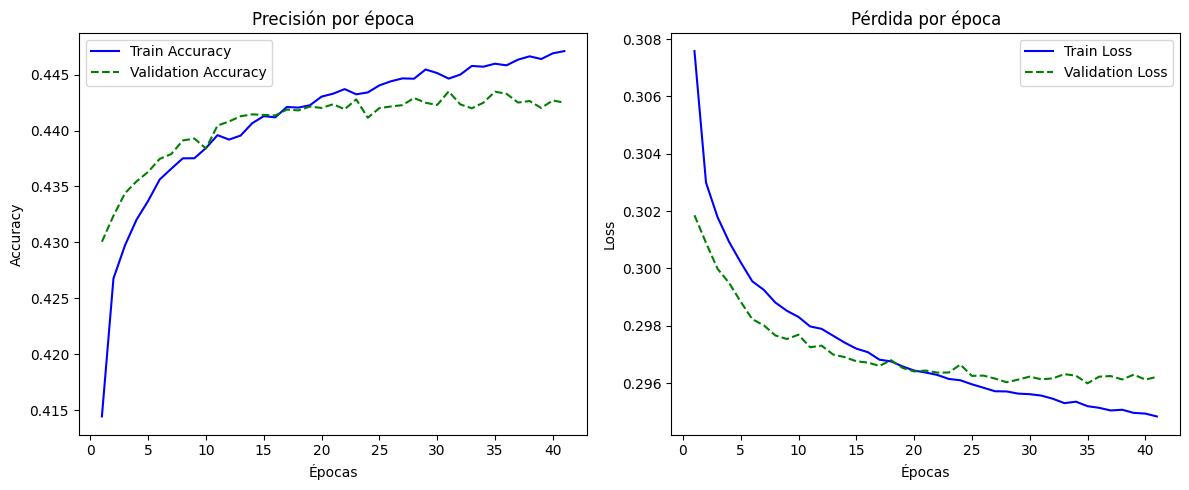

In [25]:
plot_training_history(history)

In [26]:
from sklearn.metrics import classification_report

y_pred = model.predict({'dense_input': Xts, 'program_input': Xts_int })
print(classification_report(yts.values.argmax(axis=1), y_pred.argmax(axis=1)))
acc = np.mean(y_pred.argmax(axis=1) == yts.values.argmax(axis=1))
print()
print(f"Test accuracy: {acc}")

6493/6493 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
              precision    recall  f1-score   support

           0       0.47      0.58      0.52     52173
           1       0.34      0.23      0.27     51637
           2       0.33      0.32      0.33     51112
           3       0.57      0.64      0.60     52828

    accuracy                           0.44    207750
   macro avg       0.43      0.44      0.43    207750
weighted avg       0.43      0.44      0.43    207750


Test accuracy: 0.44348977135980744


###Buscando más optimización

Se aplica una búsquedad final de un modelo optimo con la ayuda de Keras Tuner usando como base un modelo de dos capas refinando la busqueda a los tamaños de estas alrededor de los previamente encontrados

In [27]:
!pip install keras-tuner --quiet

In [28]:
import keras_tuner as kt

def build_model(hp):

    input_dense = tf.keras.Input(shape=(Xtr.shape[1],), name="dense_input")
    input_program = tf.keras.Input(shape=(1,), name="program_input")

    # Embedding layer
    embedding = tf.keras.layers.Embedding(input_dim=949, output_dim=10)(input_program)
    embedding_flat = tf.keras.layers.Flatten()(embedding)

    concat = tf.keras.layers.Concatenate()([input_dense, embedding_flat])
    # 2 layers

    # layer 1
    units = hp.Int(f"units_{0}", min_value=152, max_value=280, step=32)
    activation = hp.Choice(f"activation_{0}", values=["gelu", "tanh"])
    x = tf.keras.layers.Dense(units, activation=activation)(concat)
    x = tf.keras.layers.Dropout(hp.Float(f"dropout_{0}", 0.15, 0.25, step=0.05))(x)
    # layer 2
    units = hp.Int(f"units_{1}", min_value=96, max_value=224, step=32)
    activation = hp.Choice(f"activation_{1}", values=["gelu", "tanh"])
    x = tf.keras.layers.Dense(units, activation=activation)(x)
    x = tf.keras.layers.Dropout(hp.Float(f"dropout_{1}", 0.15, 0.25, step=0.05))(x)

    # Output
    output = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_dense, input_program], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

In [29]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="kerastuner_dir",
    project_name="accuracy_tuning"
)

In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
tuner.search({'dense_input': Xtr, 'program_input': Xtr_int}, ytr, epochs=50, validation_split=0.2, batch_size=512,
             verbose=1, callbacks=[early_stop])

Trial 10 Complete [00h 06m 05s]
val_accuracy: 0.4401753544807434

Best val_accuracy So Far: 0.4429190158843994
Total elapsed time: 00h 57m 20s


####Mejor modelo

In [31]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Mejores hiperparámetros:")
for param in best_hps.values:
    print(f"{param}: {best_hps.values[param]}")

Mejores hiperparámetros:
units_0: 184
activation_0: gelu
dropout_0: 0.25
units_1: 192
activation_1: gelu
dropout_1: 0.25


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [34]:
tuner_1 = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="kerastuner_dir",
    project_name="accuracy_tuning3"
)

Reloading Tuner from kerastuner_dir/accuracy_tuning3/tuner0.json


In [35]:
best_model_2 = tuner.get_best_models(num_models=1)[0]
best_hps_2 = tuner.get_best_hyperparameters(1)[0]

print("Mejores hiperparámetros:")
for param in best_hps.values:
    print(f"{param}: {best_hps.values[param]}")

Mejores hiperparámetros:
units_0: 184
activation_0: gelu
dropout_0: 0.25
units_1: 192
activation_1: gelu
dropout_1: 0.25


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


###Calibración con todo el conjunto de datos

####One-hot encoding variable salida

In [36]:
y = pd.get_dummies(y).astype(int)

####Descomposición PCA

In [37]:
pca = PCA(n_components=45)
pca.fit(X_scaled)
X_scaled = pca.transform(X_scaled)

#####Ajuste Columna de embedding

In [38]:
print(X_program_int.shape)
X_program_int = np.array(X_program_int).reshape(-1, 1)
print(X_program_int.shape)

(692500,)
(692500, 1)


####Creacion y ajuste modelo

In [39]:
input_dense = tf.keras.Input(shape=(X_scaled.shape[1],), name="dense_input")

input_program = tf.keras.Input(shape=(1,), name="program_input")

# Embedding layer
embedding = tf.keras.layers.Embedding(input_dim=emb_dim, output_dim=10)(input_program)
embedding_flat = tf.keras.layers.Flatten()(embedding)

concat = tf.keras.layers.Concatenate()([input_dense, embedding_flat])

x = tf.keras.layers.Dense(152, activation='gelu')(concat)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(138, activation='gelu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_dense, input_program], outputs=output)

alpha = tf.constant([0.25, 0.25, 0.25, 0.25], dtype=tf.float32)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalFocalCrossentropy(gamma=0.0, alpha=alpha),
              metrics=['accuracy'])


#####Entrenamiento

In [40]:
model.fit( {'dense_input': X_scaled, 'program_input': X_program_int}, y, epochs=30, batch_size=512,verbose=1)

Epoch 1/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4063 - loss: 0.3107
Epoch 2/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4278 - loss: 0.3025
Epoch 3/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4322 - loss: 0.3013
Epoch 4/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4333 - loss: 0.3002
Epoch 5/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4352 - loss: 0.2996
Epoch 6/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4366 - loss: 0.2989
Epoch 7/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4382 - loss: 0.2985
Epoch 8/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4386 - loss: 0.2984
Epoch 9/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4391 - loss: 0.2979
Epoch 10/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4393 - loss: 0.2978
Epoch 11/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4407 - loss: 0.2973
Epoch 12/30
1353/1353 ━━

##Predicción

La carga de datos y preprocesado inicial ya se ha ejecutado hasta la fase de labeling de columna de programas y el target encoding. Se continua ahora el proceso de separación y escalado de las matrices correspondientes

###Separación de matrices

In [41]:
X_dense_test = test_df_processed.drop(columns=['ESTU_PRGM_ACADEMICO_INT'])
X_program_int_test = test_df_processed['ESTU_PRGM_ACADEMICO_INT']

###Normalización

In [42]:
X_scaled_test = preprocessor.transform(X_dense_test)

###Descomposición PCA

In [43]:
X_pca_test = pca.transform(X_scaled_test)

###Obteniendo Predicción

In [44]:
y_pred = model.predict({'dense_input': X_pca_test, 'program_input': X_program_int_test })
y_pred = y_pred.argmax(axis=1)

9275/9275 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [45]:
y_pred[:30]

array([0, 2, 3, 0, 0, 0, 3, 3, 0, 3, 3, 2, 3, 3, 3, 1, 3, 0, 1, 1, 0, 0,
       2, 1, 1, 0, 3, 0, 0, 2])

###Dataframe de predicción

In [46]:
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
y_pred = pd.DataFrame(y_pred, columns=['RENDIMIENTO_GLOBAL'])
y_pred = y_pred.replace(dict(zip(range(4), grades)))
y_pred.head()
prediction_df = pd.concat([test_df['ID'], y_pred], axis=1).set_index('ID')
print(prediction_df.shape)
prediction_df.head()

(296786, 1)


,RENDIMIENTO_GLOBAL
ID,
550236,bajo
98545,medio-alto
499179,alto
782980,bajo
785185,bajo


###Exportando el archivo

In [47]:
prediction_df.to_csv("submission.csv")